# Определение возраста покупателей по фотографии - Исследовательский анализ данных

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. Необходимо достигнуть результата менее 7 по метрике MAE.

**Тип задачи:** регрессия.

## Описание данных

В вашем распоряжении набор фотографий людей с сайта ChaLearn Looking at People с указанием возраста.

Информация о возрасте содержится в файле csv:
* `file_name` - имя файла с фотографией
* `real_age` - возраст человека с фотографии

## План работы

**Исследовательский анализ данных:**
* Загрузка и изучение основных параметров выборки
* Изучение распределения целевого показателя
* Визуальный осмотр данных
* Выводы из исследовательского анализа данных

**Обучение модели:**
* Обучение
* Результат
* Выводы по обучению

## Настройки и импорты

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image as PILImage
from IPython.display import Image

In [2]:
folder_path = '/datasets/faces/final_files/'
csv_path = '/datasets/faces/labels.csv'

## Исследовательский анализ данных

### Загрузка и изучение основных параметров выборки

Загрузим таргет для первоначального осмотра:

In [3]:
original_df = pd.read_csv(csv_path)

Взглянем на голову, хвост и общую информацию:

In [4]:
display('Голова:', original_df.head())
display('Хвост:', original_df.tail())
original_df.info()

'Голова:'

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


'Хвост:'

,file_name,real_age
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20
7590,007612.jpg,47


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


'Информация:'

None

7591 семпл, пропусков нет, типы данных определились корректно.

Взглянем на дубликаты и дубликаты в именах файлов:

In [5]:
display(original_df.duplicated().sum())
display(original_df['file_name'].duplicated().sum())

0

0

Дубликатов нет ни в датафрейме, ни в именах файлов. Значит csv составлен без ошибок.

Загрузим сами изображения:

In [6]:
data_generator = ImageDataGenerator()
data_generator_flow = data_generator.flow_from_dataframe(original_df, 
                                                         folder_path,
                                                         x_col='file_name',
                                                         y_col='real_age',
                                                         class_mode='raw',
                                                         target_size=(150, 150),
                                                         batch_size=16,
                                                         seed= 777,
                                                         shuffle=True,
                                                        )

Found 7591 validated image filenames.


Посмотрим на основные параметры data_generator_flow:

In [7]:
display('Цветовая модель:', data_generator_flow.color_mode)
display('Количество семплов:', data_generator_flow.samples)
display('Размеры и количество каналов:', data_generator_flow.image_shape)

'Цветовая модель:'

'rgb'

'Количество семплов:'

7591

'Размеры и количество каналов:'

(150, 150, 3)

Как и прежде 7591 семпл.

### Изучение распределения целевого показателя

Взглянем на распределение таргета:

In [8]:
original_df['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Данные от младенчества (возраст 1 год) до глубокой старости (возраст 100 лет). Судя по диапазону выбросов в данных быть не должно.

Средний и медианный возраст около 30 лет (это хорошо, т.к. природа распределения должна быть примерно нормальной).

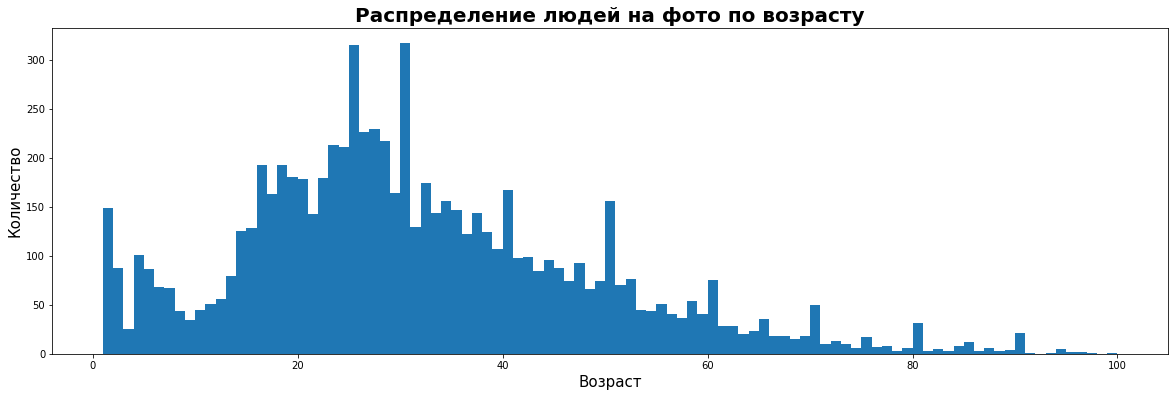

In [9]:
fig, ax = plt.subplots(figsize=(20,6))
ax.set_title('Распределение людей на фото по возрасту', fontsize=20, weight='bold')
ax.set_xlabel('Возраст', fontsize=15)
ax.set_ylabel('Количество', fontsize=15)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.hist(original_df['real_age'], bins=99);

Распределение не совсем нормальное: 
* Имеются пики на 25, 30, 40, 50 и т.д. Это наверняка связано с тем, что данные о возрасте не всегда можно получить и приходится ставить примерное округленное значение, либо с тем, что сами люди на фотографиях имеют склонность к округлению.
* Так же можно заметить что есть повышенное количество фотографий детей до 8 лет, с пиком в районе года и провалом в районе 3 лет. Это вероятнее всего можно объяснить склонностью людей фотографировать детей в "милом" возрасте и доступностью таких фотографий. Провал в районе 3 лет объяснить чем-либо сложно и сделать с этим мы ничего особо не можем. Вероятно, это как-то связано со спецификой источников сбора информаций для данной работы.

### Визуальный осмотр данных

Посмотрим оригинальные картинки и взглянем какого они разрешения:

'Имя файла:'

'001074.jpg'

'Размер:'

(853, 853, 3)

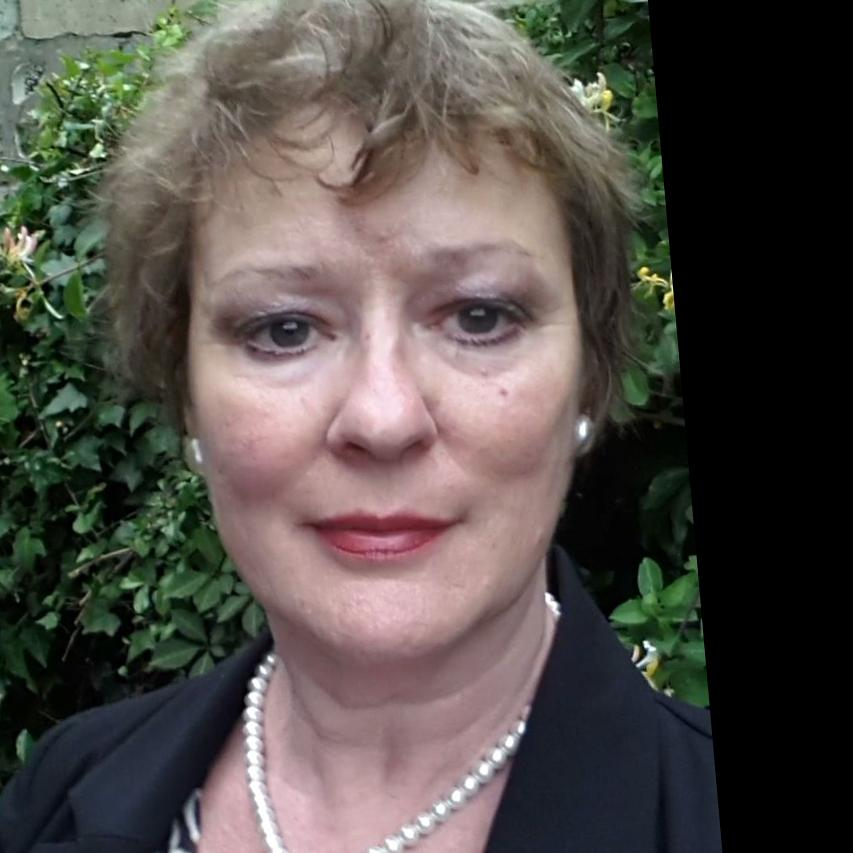

'Имя файла:'

'003476.jpg'

'Размер:'

(924, 924, 3)

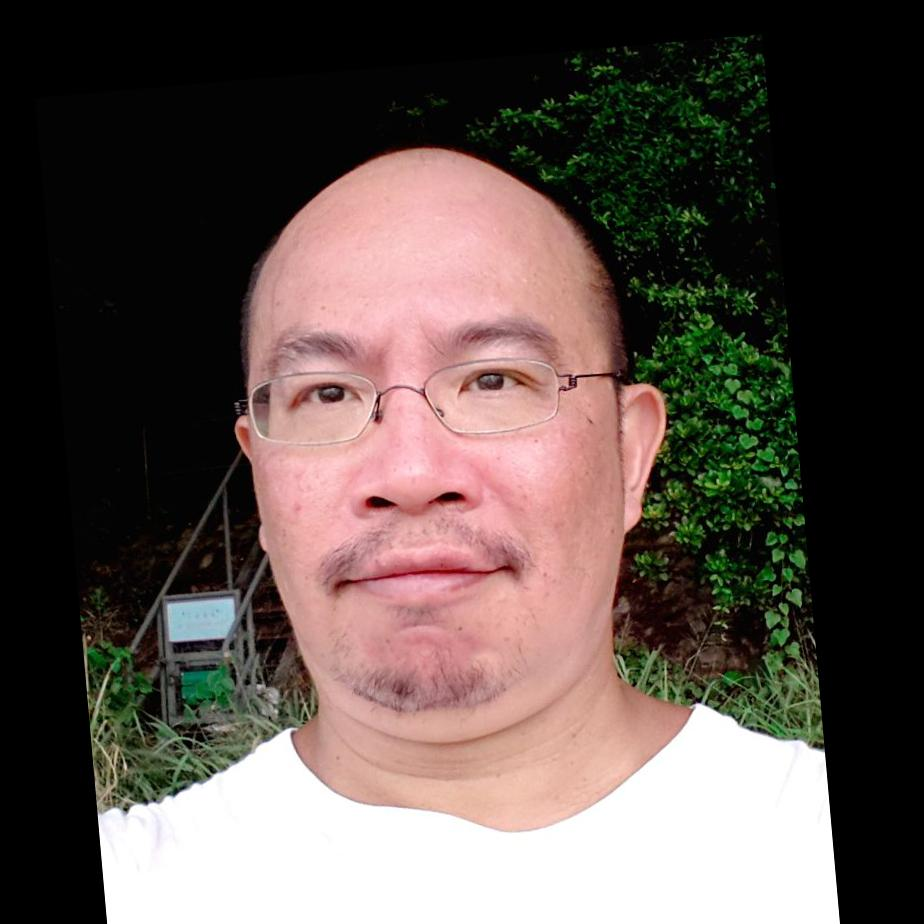

'Имя файла:'

'003487.jpg'

'Размер:'

(773, 773, 3)

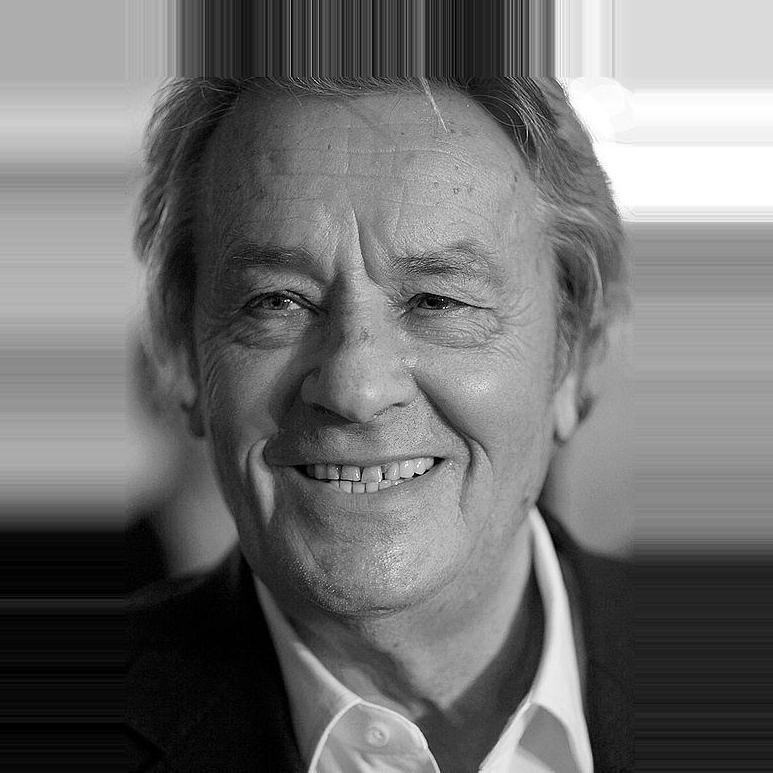

'Имя файла:'

'003846.jpg'

'Размер:'

(268, 269, 3)

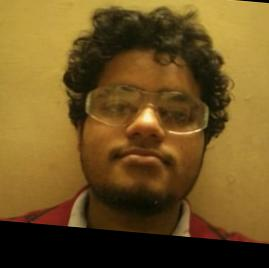

'Имя файла:'

'006403.jpg'

'Размер:'

(446, 446, 3)

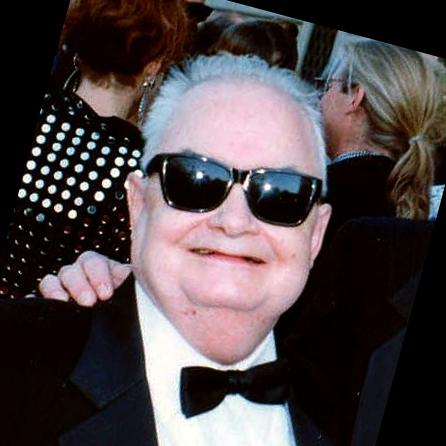

'Имя файла:'

'005085.jpg'

'Размер:'

(228, 228, 3)

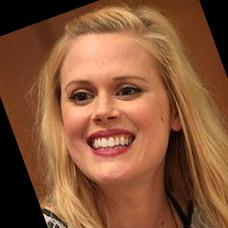

'Имя файла:'

'003855.jpg'

'Размер:'

(212, 212, 3)

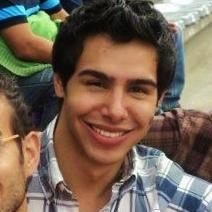

'Имя файла:'

'002893.jpg'

'Размер:'

(340, 340, 3)

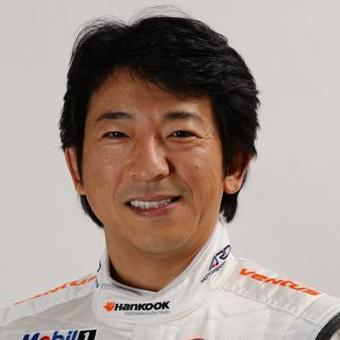

'Имя файла:'

'000439.jpg'

'Размер:'

(777, 777, 3)

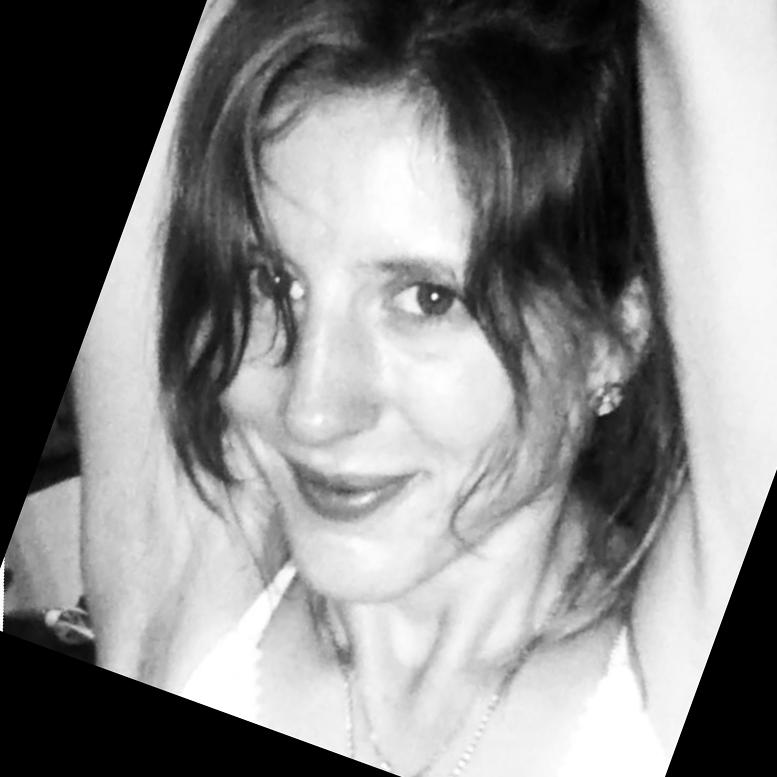

'Имя файла:'

'003040.jpg'

'Размер:'

(545, 545, 3)

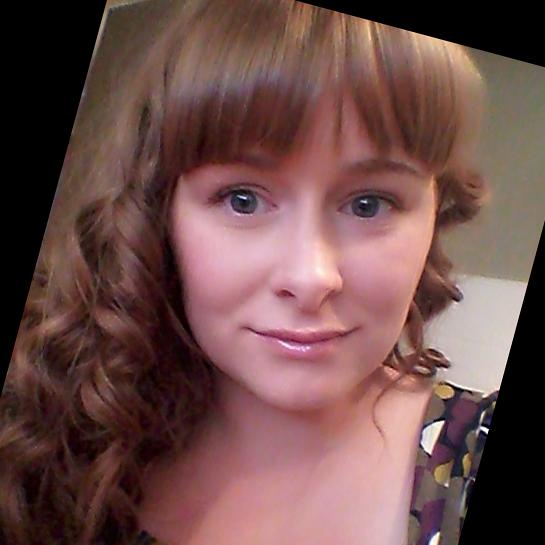

'Имя файла:'

'000737.jpg'

'Размер:'

(155, 155, 3)

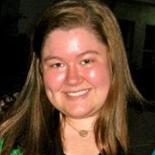

'Имя файла:'

'003267.jpg'

'Размер:'

(177, 177, 3)

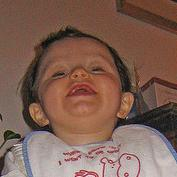

'Имя файла:'

'002011.jpg'

'Размер:'

(593, 593, 3)

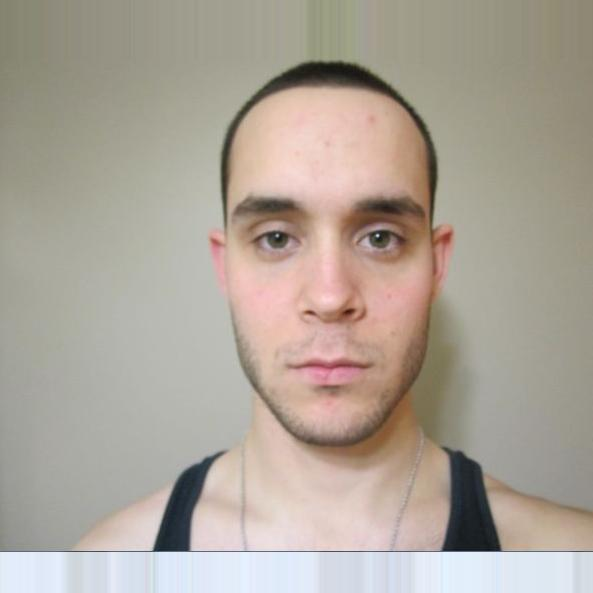

'Имя файла:'

'001270.jpg'

'Размер:'

(177, 176, 3)

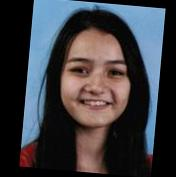

'Имя файла:'

'002063.jpg'

'Размер:'

(544, 700, 3)

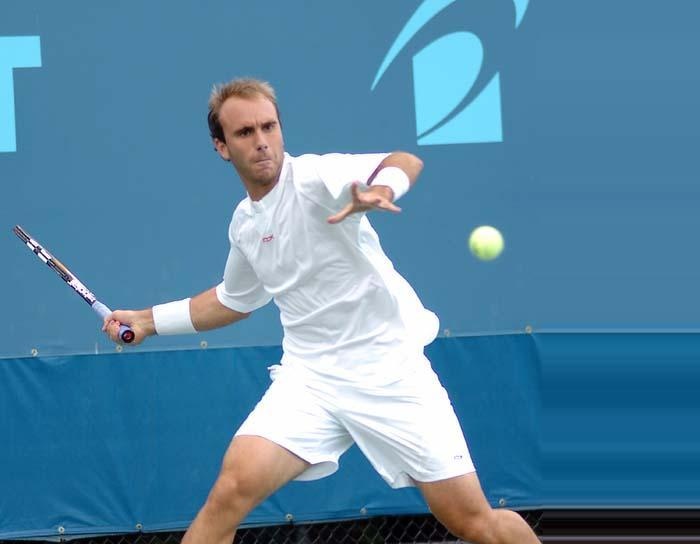

In [10]:
min_shape = float('inf')
max_shape = -float('inf')
for img_name in original_df.sample(15, random_state=777)['file_name'].values:
    img = PILImage.open(folder_path + img_name)
    array = np.array(img)
    display('Имя файла:', img_name)
    display('Размер:', array.shape)
    display(Image(filename=folder_path + img_name))
    # Соберем информацию о минимальном и максимальном количестве пикселей в 1 измерении
    min_shape = min(min_shape, array.shape[0])
    max_shape = max(max_shape, array.shape[0])

In [11]:
display(min_shape, max_shape)

155

924

Оригинальные файлы имеют самое разное разрешение. Диапазон от ~100 пикселей до ~1000. Большая часть фотографий - портреты, но есть и фото в полный рост. 

### Выводы из исследовательского анализа данных

* Не самых больших размеров датасет. Если выделить на тестовую выборку 20% Останется всего около 6000 семплов на тренировку (+ валидация, если она портебуется). Вероятнее всего потребуется предобученая CNN, возможно придётся блокировать часть её слоёв для обучения.
* Диапазон оригинальных изображений поможет в выборе оптимальной target_size при загрузке бэчкей через data_generator. Вероятнее всего стоит выбрать что-то в диапазоне 300х300 пикселей.
* В данных по таргету есть округленные значения (фото при этом без округлений говорят о возрасте). В самих фотографиях есть разные форматы, в основном это портреты, но встречаются и фото в полный рост. Наверняка это скажется в негативную сторону на результатах обучения.

## Обучение модели

### Обучение

Для обучение модели была сразу выбрана модель ResNet50. Это достаточно "умная" модель, есть возможность использовать предобученные веса и дообучить последний слой.

Изначальный план:
* Начать с размера изображений 150x150 без аугментаций кроме приведение пикселеей в диапазон [0,1]
* Начать с одного полноценного слоя в топе с relu активацией.
* Сначала попробовать не фризить backbone для обучения.
* Использовать затухающую learning_rate со стартовой величиной 5*10^-4, Adam optimiser и MSE loss, 5 эпох обучения (для отслеживания прогресса).
* Дальше в зависимости от результата вносить по одному изменению за раз пока не будет достигнут необходимый результат. 

**Код реализации:**
```python
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import numpy as np
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow import random
import pandas as pd
from tensorflow.keras.losses import MeanSquaredError as mse_loss
from tensorflow.keras.metrics import MeanSquaredError as mse_metric
from tensorflow.keras.metrics import MeanAbsoluteError as mae_metric


def load_train(path):
    target_df = pd.read_csv(path + 'labels.csv')
    path = path + 'final_files/'

    data_generator = ImageDataGenerator(rescale=1. / 255,
                                        validation_split=0.2,
                                        # width_shift_range=0.2,
                                        # height_shift_range=0.2,
                                        # horizontal_flip=True,
                                        # vertical_flip=True,
                                        # rotation_range=90,
                                        # zoom_range=0.2
                                        )

    data_generator_flow = data_generator.flow_from_dataframe(target_df,
                                                             path,
                                                             x_col='file_name',
                                                             y_col='real_age',
                                                             class_mode='raw',
                                                             subset='training',
                                                             target_size=(150, 150),
                                                             batch_size=16,
                                                             seed=777,
                                                             shuffle=True,
                                                             )

    return data_generator_flow


def load_test(path):
    target_df = pd.read_csv(path + 'labels.csv')
    path = path + 'final_files/'

    data_generator = ImageDataGenerator(rescale=1. / 255,
                                        validation_split=0.2,
                                        )

    data_generator_flow = data_generator.flow_from_dataframe(target_df,
                                                             path,
                                                             x_col='file_name',
                                                             y_col='real_age',
                                                             class_mode='raw',
                                                             subset='validation',
                                                             target_size=(150, 150),
                                                             batch_size=16,
                                                             seed=777,
                                                             shuffle=True,
                                                             )

    return data_generator_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    initial_learning_rate = 5 * (10 ** -4)
    decay_rate = 0.5

    lr_schedule = ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        # TODO поменять decay_steps
        decay_steps=1463,
        decay_rate=decay_rate)

    optimizer = Adam(learning_rate=lr_schedule)
    loss = mse_loss()
    metrics = [mae_metric()]

    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)
    model.summary()

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):
    random.set_seed(12345)

    model.fit(train_data,
              validation_data=test_data,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              batch_size=batch_size,
              verbose=2,
              )

    return model
```

По стечению обстоятельств в результате первого же обучения на 5 эпохах был достигнут необходимый результат. Наверняка его можно значительно улучшить, но в рамках этой работы дальнейшей оптимизации проводить не требуется. 

### Результат

**Вывод консоли (без информационных сообщений от tf):**
```
Found 6073 validated image filenames.
Found 1518 validated image filenames.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
=================================================================
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________
<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 380 steps, validate for 95 steps
Epoch 1/5
380/380 - 47s - loss: 192.7757 - mean_absolute_error: 10.5209 - val_loss: 318.1590 - val_mean_absolute_error: 13.2487
Epoch 2/5
380/380 - 40s - loss: 101.5679 - mean_absolute_error: 7.7312 - val_loss: 161.8094 - val_mean_absolute_error: 9.8486
Epoch 3/5
380/380 - 38s - loss: 56.9069 - mean_absolute_error: 5.8313 - val_loss: 90.5672 - val_mean_absolute_error: 7.2407
Epoch 4/5
380/380 - 38s - loss: 30.2770 - mean_absolute_error: 4.2757 - val_loss: 78.9035 - val_mean_absolute_error: 6.7603
Epoch 5/5
380/380 - 39s - loss: 16.0605 - mean_absolute_error: 3.0859 - val_loss: 73.8535 - val_mean_absolute_error: 6.5400

95/95 - 8s - loss: 73.8535 - mean_absolute_error: 6.5400
Test MAE: 6.5400
```

### Выводы по обучению

* Обучение прошло достаточно быстро, при этом данных оказалось более чем достаточно для того, чтобы обойтись без фиксации первых слоёв модели.
* Оказалось достаточно всего одного дополнительного слоя в top с одним нейроном и relu активацией. Всю работу сделали свёрточные слои resNet.
* Разрешения в 150 пикселей оказалось более, чем достаточно для неплохого определения возраста, хотя можно было бы анализировать и более крупные изображения с детализацией которая позволила бы отслеживать более тонкие детали (такие, например, как состояние кожи).
* Как видно из val_loss и mae по валидационной и по тестовой выборкам - на протяжении всего обучения они только снижаются. Это говорит о том, что без применения early stopping можно было бы добиться даже от текущих параметров модели лучшие результаты (варьируя количество эпох и learning_rate).
* **Результат, необходимый заказчику достигнут и составил 6.54 по метрике MAE на тестовой выборке.**